In [538]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

In [539]:
data = pd.read_csv("./data.csv")
print(data.head())

train_data = data[data["subject"] == 1]["shape_num"].to_numpy()

RT_train_data = data[data["subject"] == 1]["RT_trimmed"].to_numpy()
print("RT_train_data", RT_train_data)

print(train_data.shape)

real_y = train_data[:24]
real_y_add = train_data[24:24*2]
print(real_y)
print(real_y_add)

def gen_data(d):
    data = np.empty((0, 24))
    for index in d:
        #print("item?: ", index)
        # Create an array of zeros with length 24
        result_array = np.zeros(24)
        result_array[d[index] - 1] = 1
        data = np.vstack((data, result_array))
    return data

X_train_all = gen_data(train_data)

"""
y train creation:

Hetzelfde maar dus elke keer item van de volgende in de lijst en elke na 3de element is [0,...,0]
"""

y_train_all = X_train_all.copy()
y_train_all[:-1] = y_train_all[1:]


print("y_train_all.shape", y_train_all.shape[0] / 3)

y_train_all[2::3] = np.zeros(
    (int(y_train_all.shape[0]/3), 24)
)



#X_train = X_train[24:24*2]
#y_train = y_train[24:24*2]

#X_train = X_train[:576-24]
#y_train = y_train[:576-24]

#X_train = X_train[:576-24]
#y_train = y_train[:576-24]

X_train = X_train_all[:-24]
y_train = y_train_all[:-24]

X_train = X_train_all[:24]
y_train = y_train_all[:24]


X_test = X_train_all[576-(24*2):]
y_test = y_train_all[576-(24*2):]

print(X_test.shape, y_test.shape)
print("show inner", X_test, X_train)

#X_test = X_train_all[24:48]
#y_test = y_train_all[24:48]



"""
X_test = X_train[24*3:24*4]
y_test = y_train[24*3:24*4]
"""

#X_train = np.reshape(X_train, (24, -1, 24))
#X_test = np.reshape(X_test, (24, -1, 24))

X_train = np.reshape(X_train, (-1, 24, 24))
X_test = np.reshape(X_test, (-1, 24, 24))

#X_train = np.reshape(X_train, (-1, 1, 24))
#X_test = np.reshape(X_test, (-1, 1,  24))

#y_train = np.reshape(y_train, (24, -1, 24))
#y_test = np.reshape(y_test, (24, -1, 24))

#y_train = np.reshape(y_train, (-1, 1, 24))
#y_test = np.reshape(y_test, (-1, 1, 24))

y_train = np.reshape(y_train, (-1, 24, 24))
y_test = np.reshape(y_test, (-1, 24, 24))

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print(X_test)

   subject         ave          sd  block  triplet  position  shape_num    RT  \
0        1  463.309028  298.476633      1        1         1          1  1121   
1        1  463.309028  298.476633      1        1         2          2   886   
2        1  463.309028  298.476633      1        1         3          3   837   
3        1  463.309028  298.476633      1        7         1         19   843   
4        1  463.309028  298.476633      1        7         2         20  1264   

    RT_trimmed  log_RT_trimmed  change?  block>12  block>18  block>6  \
0  1060.262293        6.966272        1     False     False    False   
1   886.000000        6.786717        0     False     False    False   
2   837.000000        6.729824        0     False     False    False   
3   843.000000        6.736967        0     False     False    False   
4  1060.262293        6.966272        1     False     False    False   

   1-avg(2,3)  log_1-avg(2,3) odd_even  
0         NaN             NaN        o 

## Simulate based on custom dataset

In [540]:
# Full dataset - 1 block


## Build network wth GRU

In [541]:
def build_network(learning_rate: float = 0.05):
      model = tf.keras.Sequential()
      model.add(tf.keras.Input(shape=(1,24)))
      #model.add(tf.keras.layers.SimpleRNN(units=64, return_sequences = True, activation = "tanh"))
      model.add(tf.keras.layers.GRU(units=64, return_sequences = True, activation = "tanh"))
      #model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=24, activation="softmax")))  # Output shape should match the number of features
      model.add(tf.keras.layers.Dense(units=24, activation = "softmax")) 
      loss = tf.keras.losses.CategoricalCrossentropy()
      model.compile(optimizer = \
         tf.keras.optimizers.Adam(learning_rate = learning_rate), loss = loss, metrics = ["accuracy"])	
      return model


In [542]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_predict_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Predicting: end of batch {}; got log keys: {}".format(batch, keys))
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        print("End epoch {} of training; got log keys: {}".format(epoch, keys))

In [543]:
def train_model():
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    res = model.fit(X_train, y_train, epochs = 24, verbose=1)
    return res

In [544]:
def show_res(res, verbose: bool = False):
    if verbose:
        print(res.history)
    fig, axs = plt.subplots(2,2)
    axs[0, 0].set_title("training loss")
    axs[0, 0].plot(res.history["loss"])
    axs[0, 1].set_title("training accuracy")
    axs[0, 1].plot(res.history["accuracy"])
    axs[1, 0].set_title("test loss")
    #axs[1, 0].plot(res.history["val_loss"])
    axs[1, 1].set_title("test accuracy")
    #axs[1, 1].plot(res.history["val_accuracy"])
    plt.show()

(1, 24, 24) (1, 24, 24) (2, 24, 24) (2, 24, 24)
Epoch 1/24
1/1 [==============================] - 1s 1s/step - loss: 2.1230 - accuracy: 0.1250
Epoch 2/24
1/1 [==============================] - 0s 10ms/step - loss: 1.7104 - accuracy: 0.5000
Epoch 3/24
1/1 [==============================] - 0s 8ms/step - loss: 1.6456 - accuracy: 0.1667
Epoch 4/24
1/1 [==============================] - 0s 10ms/step - loss: 1.3201 - accuracy: 0.3333
Epoch 5/24
1/1 [==============================] - 0s 7ms/step - loss: 1.1013 - accuracy: 0.4167
Epoch 6/24
1/1 [==============================] - 0s 7ms/step - loss: 0.5925 - accuracy: 0.6667
Epoch 7/24
1/1 [==============================] - 0s 6ms/step - loss: 0.4295 - accuracy: 0.6667
Epoch 8/24
1/1 [==============================] - 0s 7ms/step - loss: 0.2690 - accuracy: 0.6667
Epoch 9/24
1/1 [==============================] - 0s 6ms/step - loss: 0.1582 - accuracy: 0.6667
Epoch 10/24
1/1 [==============================] - 0s 7ms/step - loss: 0.0973 - accurac

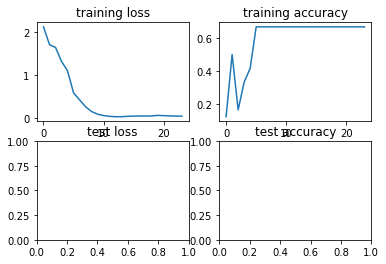

[[[7.91304279e-03 2.82360031e-03 6.39741775e-03 ... 2.27725715e-03
   3.55318887e-03 1.49463431e-03]
  [3.17521481e-04 6.01190666e-04 2.33184866e-04 ... 2.86809693e-04
   3.37606849e-04 4.81151837e-05]
  [2.50783954e-02 9.08650085e-03 3.00257318e-02 ... 6.21676072e-02
   7.17935432e-03 2.07631774e-02]
  ...
  [9.21477113e-05 1.05833824e-04 6.55275358e-07 ... 7.30635831e-04
   8.90552546e-05 9.91454959e-01]
  [6.11874741e-03 2.84251967e-03 2.69940465e-05 ... 2.77063809e-02
   4.96529229e-03 3.56491748e-03]
  [3.43546793e-02 1.27322823e-02 7.10734678e-03 ... 1.27686933e-01
   1.09045487e-02 2.68918984e-02]]

 [[3.77821698e-06 2.02190199e-06 9.99699831e-01 ... 1.88027889e-06
   2.32757202e-06 1.39022006e-06]
  [4.93848231e-04 6.08925067e-04 1.33004249e-03 ... 2.09921934e-02
   1.48797536e-03 7.19349890e-04]
  [4.71771657e-02 2.43942384e-02 1.12265022e-02 ... 9.68997180e-02
   1.64373815e-02 1.30642205e-02]
  ...
  [1.27676921e-03 5.25380077e-04 3.91786195e-08 ... 2.44013453e-03
   3.35058

In [545]:
model = build_network()
res = train_model()
model.summary()

show_res(res)

print(model.predict(X_test))
print(model.predict(X_test).shape)

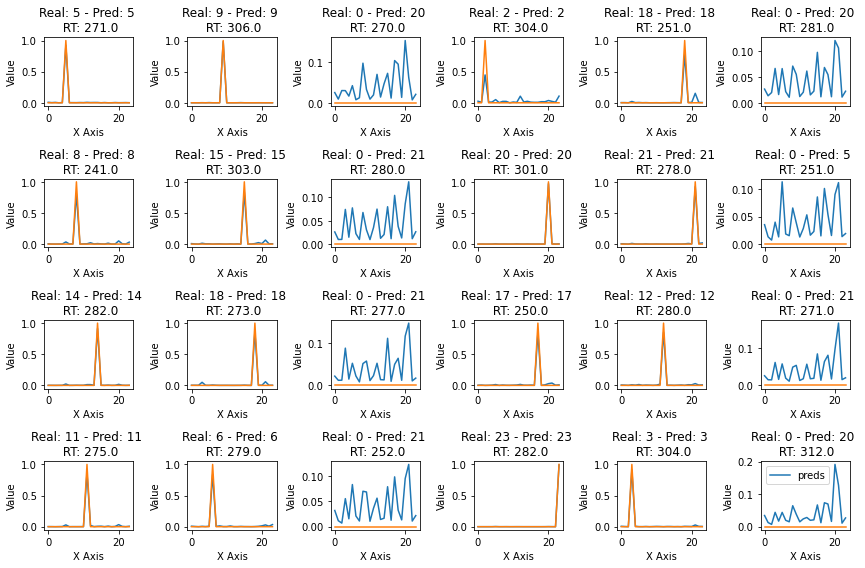

In [546]:
pred = model.predict(X_test)

# Create 24 subplots
fig, axes = plt.subplots(4, 6, figsize=(12, 8))

variances = np.empty(24)

for i, ax in enumerate(axes.flatten()):
    """
    print("i", i)
    #ax.plot(pred[i, 0, :])
    ax.plot(pred[i, 0, :], label="preds")
    print("pred: i, ", pred[i][0])
    ax.plot(y_test[i, 0, :])
    #ax.plot(y_test[i])
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Value')
    ax.set_title(f'Plot {i+1}, {np.argmax(y_test[i])} - {np.argmax(pred[i, 0, :])}')
    """
    #print("i", i)
    #ax.plot(pred[i, 0, :])
    ax.plot(pred[0, i, :], label="preds")
    #print("pred: i, ", pred[0][i])
    ax.plot(y_test[0, i, :])
    #ax.plot(y_test[i])
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Value')
    ax.set_title(
    f'Real: {np.argmax(y_test[0, i])} - Pred: {np.argmax(pred[0, i, :])} \n RT: {RT_train_data[-24:][i]}'
    )
    #print("var", np.var(pred[0, i, :]))
    variances[i] = np.var(pred[0, i, :])

plt.tight_layout()
plt.legend()
plt.show()

### Stronger predictions in late triplet component
More evident with increased epochs (ie 10 instead of 1)

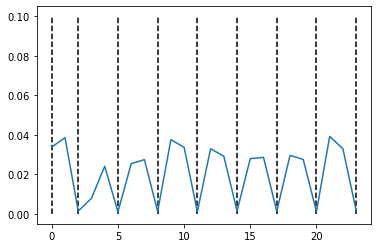

In [547]:
plt.plot(variances)
triplets = [0,2,5,8,11,14,17,20,23]
plt.vlines(triplets, ymin=0.0, ymax=0.1, color="black", linestyle="--")
plt.show()


### Online measure

In [548]:
# Generate a random 3D array for demonstration
preds = model.predict(X_test)
print(preds.shape)

# Find the index of the maximum value
max_index = np.argmax(preds[0, 0])
print(max_index)

# Create a new array with all zeros and set the maximum value to 1
new_array = np.zeros_like(np.arange(24))
new_array[max_index] = 1

# Print the result
print(new_array.shape)
print(preds[0])
print(new_array)
print(y_test[0])

(2, 24, 24)
5
(24,)
[[7.91304279e-03 2.82360031e-03 6.39741775e-03 1.68577157e-04
  3.27191874e-03 9.24128473e-01 2.92773917e-03 2.63220654e-03
  2.34990334e-03 4.27227654e-03 3.01432167e-03 7.08079617e-03
  3.95315886e-03 5.09367511e-03 4.99316351e-03 6.65956468e-04
  3.96415964e-03 3.58237710e-04 9.79578006e-04 4.08621412e-03
  1.60067738e-03 2.27725715e-03 3.55318887e-03 1.49463431e-03]
 [3.17521481e-04 6.01190666e-04 2.33184866e-04 1.66113162e-03
  3.59231199e-04 2.99457135e-03 5.90254611e-04 4.71006846e-04
  1.41105650e-03 9.83201563e-01 3.28666531e-04 3.00915301e-04
  2.83564528e-04 8.19513923e-04 2.64188345e-03 5.37013868e-04
  6.08475821e-04 2.63541006e-04 2.50025332e-04 8.29431927e-04
  6.23636472e-04 2.86809693e-04 3.37606849e-04 4.81151837e-05]
 [2.50783954e-02 9.08650085e-03 3.00257318e-02 2.99083870e-02
  1.64665245e-02 4.20655087e-02 7.42126629e-03 1.23735964e-02
  9.72484946e-02 3.27675901e-02 8.97247344e-03 1.93322711e-02
  6.97986037e-02 1.40857752e-02 4.67144772e-02 7

{'name': 'gru_52', 'trainable': True, 'dtype': 'float32', 'return_sequences': True, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'time_major': False, 'units': 64, 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'recurrent_initializer': {'class_name': 'Orthogonal', 'config': {'gain': 1.0, 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'recurrent_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'recurrent_constraint': None, 'bias_constraint': None, 'dropout': 0.0, 'recurrent_dropout': 0.0, 'implementation': 2, 'reset_after': True}
{'name': 'dense_52', 'trainable': True, 'dtype': 'float32', 'units': 24, 'activation': 'softmax', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initial

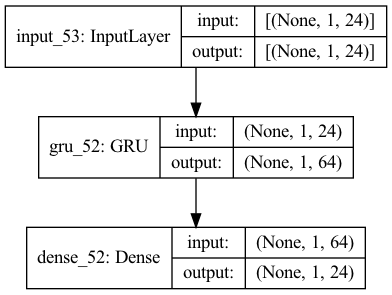

In [549]:
for layer in model.layers: 
    #print(layer.get_config(), layer.get_weights())
    print(layer.get_config())
    #print(np.array(layer.get_weights()))
    
# pydot and graphviz required voor plot
tf.keras.utils.plot_model(model, to_file="model_plot.png", show_shapes=True, show_layer_names=True)